In [1]:
import geopandas as gpd
import rasterio
import numpy as np
import pandas as pd
from shapely.geometry import Point
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
np.random.seed(42)


## DATA LOADING SECTION

In [2]:

# Load data
fire_points_path = r"E:\New folder (3)\FFRM_Lumbini\Fire Points\fire2024_25.shp"
fire_points = gpd.read_file(fire_points_path)

raster_path = r"E:\New folder (3)\FFRM_Lumbini\New Folder\FFRM5.tif"
raster = rasterio.open(raster_path)

# CRS matching
if fire_points.crs != raster.crs:
    print(f"Reprojecting fire points from {fire_points.crs} to {raster.crs}")
    fire_points = fire_points.to_crs(raster.crs)


## RASTER VALUE EXTRACTION FUNCTION

In [3]:
def extract_values(points, raster_obj):
    """
    Extract raster values at point locations.
    
    Parameters:
    -----------
    points : GeoDataFrame
        Points with geometry to extract values for
    raster_obj : rasterio.DatasetReader
        Opened raster dataset
        
    Returns:
    --------
    list
        Extracted raster values for each point
    """
    coords = []
    for geom in points.geometry:
        if hasattr(geom, 'x'):
            coords.append((geom.x, geom.y))
        else:
            # For non-point geometries, use centroid
            centroid = geom.centroid
            coords.append((centroid.x, centroid.y))
    
    # Sample all points at once for better performance
    try:
        samples = list(raster_obj.sample(coords))
        values = [s[0] if not np.isnan(s[0]) else None for s in samples]
        return values
    except Exception as e:
        print(f"Sampling error: {e}")
        return [None] * len(coords)

## FIRE POINTS PROCESSING

In [4]:
print("Processing fire points...")
# Extract risk scores for fire occurrence locations
fire_points["risk_score"] = extract_values(fire_points, raster)

# Remove points that couldn't be extracted (None or NaN values)
original_fire_count = len(fire_points)
fire_points = fire_points.dropna(subset=["risk_score"])
print(f"Fire points with valid risk scores: {len(fire_points)}/{original_fire_count}")

Processing fire points...
Fire points with valid risk scores: 14611/14611


## BACKGROUND POINTS GENERATION

In [5]:
print("\nGenerating background points for comparison...")

# Get raster bounds for random point generation
bounds = raster.bounds

# Generate twice as many background points as fire points for robust comparison
n_background = len(fire_points) * 2
background_points = []
max_attempts = n_background * 10  # Safety limit to prevent infinite loops

print(f"Target: {n_background} background points")

# Generate random points within raster bounds
for attempt in range(max_attempts):
    # Exit loop if we've generated enough points
    if len(background_points) >= n_background:
        break
        
    # Generate random coordinates within raster bounds
    x = np.random.uniform(bounds.left, bounds.right)
    y = np.random.uniform(bounds.bottom, bounds.top)
    point = Point(x, y)
    
    # Validate point by checking if we can extract a valid raster value
    try:
        val = list(raster.sample([(x, y)]))[0][0]
        if not np.isnan(val):  # Only keep points with valid data
            background_points.append(point)
    except:
        # Skip points that cause errors (e.g., outside valid data area)
        pass
    
    # Progress reporting
    if (attempt + 1) % 5000 == 0:
        print(f"  Progress: {len(background_points)}/{n_background} points")

print(f"Successfully generated {len(background_points)} background points")


Generating background points for comparison...
Target: 29222 background points
  Progress: 5000/29222 points
  Progress: 10000/29222 points
  Progress: 15000/29222 points
  Progress: 20000/29222 points
  Progress: 25000/29222 points
Successfully generated 29222 background points


## BACKGROUND POINTS PROCESSING

In [6]:
# Create GeoDataFrame for background points
background_gdf = gpd.GeoDataFrame(geometry=background_points, crs=fire_points.crs)

# Extract risk scores for background points
background_gdf["risk_score"] = extract_values(background_gdf, raster)

# Remove invalid background points
original_bg_count = len(background_gdf)
background_gdf = background_gdf.dropna(subset=["risk_score"])
print(f"Background points with valid risk scores: {len(background_gdf)}/{original_bg_count}")

Background points with valid risk scores: 29222/29222


## DATA VALIDATION AND SUMMARY STATISTICS

In [7]:
print(f"\n" + "="*50)
print("DATA SUMMARY")
print("="*50)

print(f"Fire points: {len(fire_points)}")
print(f"Background points: {len(background_gdf)}")

# Calculate and display summary statistics
fire_mean = fire_points['risk_score'].mean()
fire_std = fire_points['risk_score'].std()
bg_mean = background_gdf['risk_score'].mean()
bg_std = background_gdf['risk_score'].std()

print(f"Fire points risk - Mean: {fire_mean:.3f}, Std: {fire_std:.3f}")
print(f"Background risk - Mean: {bg_mean:.3f}, Std: {bg_std:.3f}")


DATA SUMMARY
Fire points: 14611
Background points: 29222
Fire points risk - Mean: -inf, Std: inf
Background risk - Mean: -inf, Std: inf


C:\Users\jkwrs\miniconda3\envs\roc_env\Lib\site-packages\numpy\_core\_methods.py:51: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\jkwrs\miniconda3\envs\roc_env\Lib\site-packages\pandas\core\nanops.py:1025: RuntimeWarning: overflow encountered in cast
  result = result.astype(dtype, copy=False)


## ROC ANALYSIS

In [8]:
# Prepare data for ROC analysis
# 1 = fire point, 0 = background point
y_true = [1] * len(fire_points) + [0] * len(background_gdf)
y_scores = list(fire_points["risk_score"]) + list(background_gdf["risk_score"])

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

print(f"\n" + "="*50)
print("RESULTS")
print("="*50)
print(f"AUC Score: {auc:.3f}")

# Interpret AUC score
if auc >= 0.9:
    interpretation = "Excellent discrimination"
elif auc >= 0.8:
    interpretation = "Good discrimination" 
elif auc >= 0.7:
    interpretation = "Fair discrimination"
elif auc >= 0.6:
    interpretation = "Poor discrimination"
else:
    interpretation = "Failed discrimination"

print(f"Interpretation: {interpretation}")


RESULTS
AUC Score: 0.848
Interpretation: Good discrimination


## VISUALIZATION

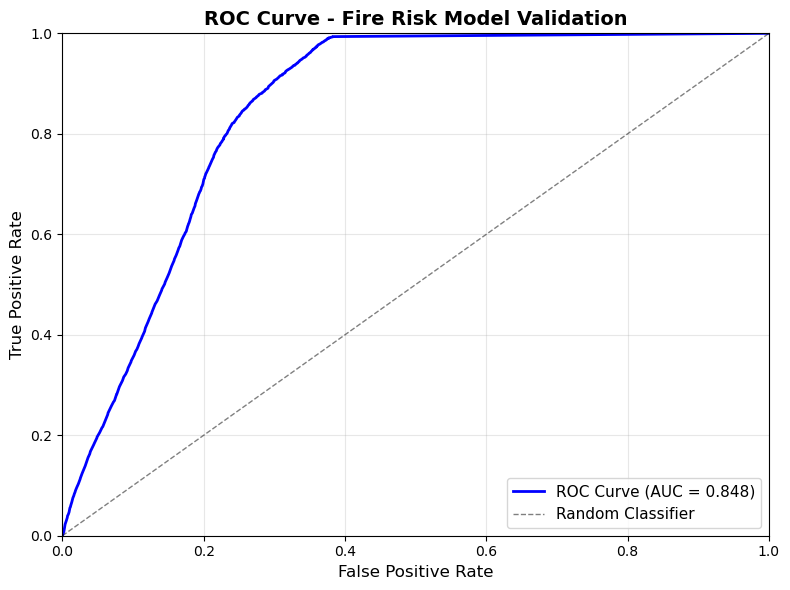

In [9]:
# Create ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random Classifier')

# Customize plot appearance
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Fire Risk Model Validation', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])

# Save and display plot
plt.tight_layout()
plt.savefig("roc_ffrm.png", dpi=300, bbox_inches='tight')
plt.show()

## CLEANUP

In [10]:
# Close raster file
raster.close()